In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

import time


In [14]:
resnet_model_names = ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']
resnets = {}
for name in resnet_model_names:
    model = torch.hub.load('pytorch/vision:v0.9.0', name, pretrained=False)
    resnets[name] = model
    print(name, sum(p.numel() for p in model.parameters()), sum(p.numel() for p in model.parameters() if p.requires_grad))

densenet_model_names = ['densenet121', 'densenet169', 'densenet201', 'densenet161']
densenets = {}
for name in densenet_model_names:
    model = torch.hub.load('pytorch/vision:v0.9.0', name, pretrained=False)
    densenets[name] = model
    print(name, sum(p.numel() for p in model.parameters()), sum(p.numel() for p in model.parameters() if p.requires_grad))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


resnet18 11689512 11689512
resnet34 21797672 21797672


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


resnet50 25557032 25557032


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


resnet101 44549160 44549160


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


resnet152 60192808 60192808
densenet121 7978856 7978856


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


densenet169 14149480 14149480


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


densenet201 20013928 20013928


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


densenet161 28681000 28681000


In [ ]:
model = densenets["densenet201"]
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.numel())

# Helper and data loader


In [3]:
suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
def humansize(nbytes):
    i = 0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[i])

def print_cuda_mem(pref=''):
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0) 
    a = torch.cuda.memory_allocated(0)
    f = r-a  # free inside reserved
    print(pref, "Total: " + humansize(t) + ", Reserved: " + humansize(r) + 
          ", Allocated: " + humansize(a) + ", Free inside reserved: " + humansize(f))
    
transform_aug = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

transform = transforms.Compose([
    # transforms.Resize(256),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())



Files already downloaded and verified


In [11]:
def make_sure_models_not_in_gpu():
    for name in list(resnets.keys()):
        resnets[name].to('cpu')
    for name in list(densenets.keys()):
        densenets[name].to('cpu')

make_sure_models_not_in_gpu()
nets = [resnets, densenets]
data = {}
batch_sizes = [32, 64, 128, 256]
num_epochs = 1

for net in nets:
    models_dict = net
    model_names = list(models_dict.keys())
    for name in model_names:
        mem_in_diff_bs = []
        print(name)
        model = models_dict[name]
        if torch.cuda.is_available():
            model.to('cuda')
        for bs in batch_sizes: 
            # Data loader
            train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                    batch_size=bs, 
                                                    shuffle=True)

            test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                    batch_size=bs, 
                                                    shuffle=False)

            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()

            for epoch in range(num_epochs):
                # t0 = time.time()
                running_loss = 0
                model.train()
                # print_cuda_mem("Pre train")
                for images, labels in (train_loader):
                    if torch.cuda.is_available():
                        images = images.to('cuda')
                        labels = labels.to('cuda')
                    # print_cuda_mem()
                    outputs = model(images)
                    # print_cuda_mem()
                    loss = criterion(outputs, labels)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()
                # else:
                    # print("Training loss: {}".format(running_loss / len(train_loader)))
                # print('{} seconds'.format(time.time() - t0))
            stats = torch.cuda.memory_stats()
            peak_bytes_requirement = stats["allocated_bytes.all.peak"]
            print("batch_size: ", bs, " ", f"Peak memory requirement: {peak_bytes_requirement / 1024 ** 3:.2f} GB")
            mem_in_diff_bs.append(peak_bytes_requirement / 1024 ** 3)
        
        model.to('cpu') # move model back to cpu to release mem
        data[name] = mem_in_diff_bs
print(data)


resnet18
batch_size:  32   Peak memory requirement: 0.33 GB
batch_size:  64   Peak memory requirement: 0.35 GB
batch_size:  128   Peak memory requirement: 0.29 GB
batch_size:  256   Peak memory requirement: 0.37 GB
resnet34
batch_size:  32   Peak memory requirement: 0.40 GB
batch_size:  64   Peak memory requirement: 0.42 GB
batch_size:  128   Peak memory requirement: 0.47 GB
batch_size:  256   Peak memory requirement: 0.57 GB
resnet50
batch_size:  32   Peak memory requirement: 0.49 GB
batch_size:  64   Peak memory requirement: 0.54 GB
batch_size:  128   Peak memory requirement: 0.66 GB
batch_size:  256   Peak memory requirement: 0.89 GB
resnet101
batch_size:  32   Peak memory requirement: 0.80 GB
batch_size:  64   Peak memory requirement: 0.88 GB
batch_size:  128   Peak memory requirement: 1.04 GB
batch_size:  256   Peak memory requirement: 1.37 GB
resnet152
batch_size:  32   Peak memory requirement: 1.06 GB
batch_size:  64   Peak memory requirement: 1.18 GB
batch_size:  128   Peak mem

In [46]:
def draw(data):
    color = ['r','g','b','c']
    plt.figure(figsize=(20,5))
    resnet_lines = []
    densenet_lines = []
    for name in data.keys():
        if name.startswith("resnet"):
            model = resnets[name]
            model_size = sum(p.numel() for p in model.parameters())
            x = [model_size] * len(data[name])
            plt.scatter(x, data[name], marker='^', s=(model_size/10000000 * 4) ** 2, color=color)
            plt.annotate(name, # this is the text
                    (x[0],data[name][0]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-20), # distance from text to points (x,y)
                    ha='center', size=13) # horizontal alignment can be left, right or center
            resnet_lines.append(list(zip(x, data[name])))
            
        else:
            model = densenets[name]
            model_size = sum(p.numel() for p in model.parameters())
            x = [model_size] * len(data[name])
            plt.scatter(x, data[name], marker='o', s=(model_size/10000000 * 4) ** 2, color=color)
            plt.annotate(name, # this is the text
                    (x[0],data[name][3]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-20), # distance from text to points (x,y)
                    ha='center', size=13) # horizontal alignment can be left, right or center
            densenet_lines.append(list(zip(x, data[name])))
        
    transposed_resnet_lines = []
    for j in range(len(resnet_lines[0])):
        transposed_resnet_lines.append([])
        for i in range(len(resnet_lines)):
            transposed_resnet_lines[j].append(resnet_lines[i][j])
    unzip_resnet_lines = []
    for idx, line in enumerate(transposed_resnet_lines):
        unzip_line = zip(*line)
        x, y = list(unzip_line)
        plt.plot(x, y, color=color[idx])
    
    transposed_densenet_lines = []
    for j in range(len(densenet_lines[0])):
        transposed_densenet_lines.append([])
        for i in range(len(densenet_lines)):
            transposed_densenet_lines[j].append(densenet_lines[i][j])
    unzip_densenet_lines = []
    for idx, line in enumerate(transposed_densenet_lines):
        unzip_line = zip(*line)
        x, y = list(unzip_line)
        plt.plot(x, y, color=color[idx])
        
    r_patch = mpatches.Patch(color='red', label='Batch Size=32')
    g_patch = mpatches.Patch(color='g', label='Batch Size=64')
    b_patch = mpatches.Patch(color='b', label='Batch Size=128')
    c_patch = mpatches.Patch(color='c', label='Batch Size=256')

    resnets_legend = plt.Line2D((0,1),(0,0), color='k', marker='^', linestyle='', label='Resnets with different model sizes')
    densenet_legend = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='', label='Densenets with different model sizes')
    plt.legend(handles=[r_patch, g_patch, b_patch, c_patch, resnets_legend, densenet_legend], loc=4)
    plt.ylabel("GPU peak memory requirement in GBs")
    plt.xlabel("model parameter counts")
    plt.title("ResNet and DenseNet GPU peak memory consumption requirement of different model sizes and batch sizes")
    plt.show()
    # plt.savefig('/content/drive/My Drive/CEplotAUG.png')

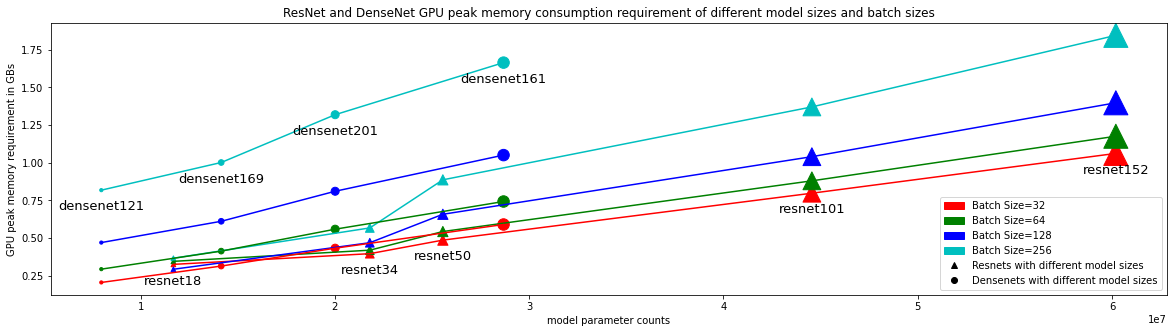

In [47]:
from matplotlib import pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import math
data_from_print = {'resnet18': [0.32606077194213867, 0.34607744216918945, 0.2935943603515625, 0.36682605743408203], 'resnet34': [0.39693117141723633, 0.4201216697692871, 0.4696769714355469, 0.5678110122680664], 'resnet50': [0.48690319061279297, 0.5438461303710938, 0.6583428382873535, 0.886847972869873], 'resnet101': [0.7980923652648926, 0.8802428245544434, 1.0403938293457031, 1.3704614639282227], 'resnet152': [1.0619640350341797, 1.1759748458862305, 1.3978934288024902, 1.8451485633850098], 'densenet121': [0.20613956451416016, 0.29433250427246094, 0.4706578254699707, 0.8183035850524902], 'densenet169': [0.31479644775390625, 0.4138660430908203, 0.6118302345275879, 1.0017542839050293], 'densenet201': [0.433380126953125, 0.5593624114990234, 0.8110108375549316, 1.3188815116882324], 'densenet161': [0.5905027389526367, 0.7429933547973633, 1.050858974456787, 1.6643128395080566]}

draw(data_from_print)